In [1]:
import os
import gym
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import ppaquette_gym_doom

In [2]:
# Create a classic Doom environment with Gym
env = gym.make('ppaquette/DoomDefendCenter-v0')

INFO:gym.envs.registration:Making new env: ppaquette/DoomDefendCenter-v0
[2017-05-09 22:08:04,081] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
# Computer vision utils
%matplotlib inline
from PIL import Image
from scipy.stats import threshold
from scipy.signal import medfilt
from scipy.misc import toimage
import time
import pylab as pl
from IPython import display

# Draw function refreshes every 1000 frames
frame_count = 0
refresh_rate = 1000

def encode_screen(observation):
  # Crop & downsampling & grayscale
  cropped = observation[150:230:3, ::2 , :]
  r = cropped[:,:,0]
  return projection(pixelate(r))

def show(mat):
  global frame_count
  global refresh_rate
  if frame_count % refresh_rate == 0:
    plt.imshow(toimage(mat))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #toimage(mat).show()
  frame_count += 1
  frame_count = frame_count % 1000

def plot_inline(data):
    global frame_count
    global refresh_rate
    if frame_count % refresh_rate == 0:
      plt.clf()
      plt.plot(data)
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1)
    frame_count += 1
    frame_count = frame_count % 3000

"""
Coarse pixelate
"""
def pixelate(observation):
  global frame_count
  # Threshold
  m = threshold(observation, threshmin=100, threshmax=None, newval=0)
  # Remove noise
  m = medfilt(m, 3)
  return m

def projection(pixels):
  # Horizontal projection
  _,w = pixels.shape
  proj = np.zeros(w)
  for x in range(w):
    proj[x] = np.sum(pixels[:,x])
    
  proj -= np.min(proj)
  proj = np.gradient(proj)[1:-1] # Remove edges
  proj = proj > 100
  proj.astype(int)
  # plot_inline(proj)

  # Reduce
  pj = []
  count = np.count_nonzero
  start = 0
  stride = 15
  while len(proj[start:start+stride])>0:
    # pj.append(count(proj[start:start+stride]) > 3)
    pj.append(np.mean(proj[start:start+stride]))
    start += stride+1
  pj = np.around(pj, decimals=1)
  plot_inline(pj)
  return str(pj)

In [4]:
# Agent
class QAgent:
  def __init__(self,\
               learn_rate=0.05,\
               observation_encoder=lambda x: x,\
               verbose=True):
    self.alpha = 0.90 # Probability of re-learning 
    self.policy = dict() # Q: (state,action) => value
    self.total_reward = 0
    self.learn_rate = learn_rate
    self.action_mapping = {} # Map [action str] => [action object]
    self.observation_encoder = observation_encoder
    self.verbose = verbose
    self.reset()
    
  def reset(self):
    self.prev_state = 0
    self.total_reward = 0
        
  def learn_aggregate(self, observation, observation_, action, reward):
    # Encode [observation] => [state]
    state  = self.observation_encoder(observation)
    state_ = self.observation_encoder(observation_)
    self.learn_Q(state, state_, str(action), reward)
    self.action_mapping[str(action)] = action
    self.prev_state = state
    self.total_reward += reward

  """
  Predict the reward we would get
  if take [action] on [state]
  """
  def learn_Q(self, state, state_, action, reward):
    curr_Q  = self.Q(state, action)
    _,max_Q = self.find_best_action(state_)
    new_Q   = curr_Q + self.alpha*(reward + self.learn_rate * max_Q - curr_Q)
    if state in self.policy:
      self.policy[state][action] = reward # Always overwrite
    else: self.policy[state] = {action: new_Q}

  """
  Find maximum possible reward we would get
  from the best action attempted on [state]
  """
  def find_best_action(self, state):
    if state in self.policy:
      max_Q    = -1
      best_act = -1
      for a,r in self.policy[state].items():
        if r > max_Q:
          best_act = a
          max_Q = r
      return (best_act, max_Q)
    else: return (-1,-1)
    
  def decode_action(self, action):
    if action not in self.action_mapping:
      return None
    else: 
      return self.action_mapping[action]

  """
  Get recorded Q value of (state, action)
  """
  def Q(self, state, action):
    if state in self.policy:
      if action in self.policy[state]:
        return self.policy[state][action]
      else: return -1
    else: return -1
  
  @staticmethod
  def load(path, default):
    if os.path.isfile(path):
      with open(path,'rb') as f:
        return pickle.load(f) 
    else:
      print('MODEL NOT FOUND, initialising a brand new one.')
      return default

  @staticmethod
  def save(path,agent):
    with open(path,'wb+') as f:
      return pickle.dump(agent, f)



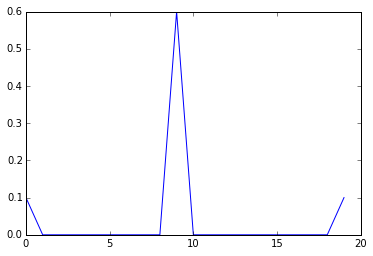

All 400 episodes of training are DONE.


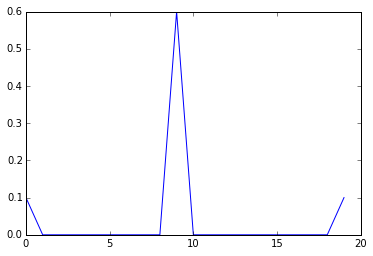

In [5]:
# Play
model_name = 'QAgent.pkl'
score_records = [] # Scores of each round
turn_records = [] # Number of turns lasting each round
num_episodes = 400
all_actions = set(range(3)) # Attack / Right / Left

bot = QAgent.load(model_name,\
                  QAgent(learn_rate=0.667, \
                  observation_encoder=encode_screen))

for i in range(num_episodes):
  if num_episodes<25 or i % 25 == 0:
    print('Ep#{} started...'.format(i))
  observation = env.reset()
  num_turns = 0
  while True:
    env.render()
    
    # Try to find best action, otherwise, random
    state = bot.observation_encoder(observation)
    action, _ = bot.find_best_action(state)
    if action == -1:
      action = env.action_space.sample()
    else:
      # print('... Best action : ', action)
      action = bot.decode_action(action)

    observation_, reward, done, info = env.step(action)
    bot.learn_aggregate(observation, observation_, action, reward)
    observation = np.copy(observation_)
    num_turns  += 1
    if done:
      score_records.append(bot.total_reward)
      turn_records.append(num_turns)
      if num_episodes<25 or i % 25 == 0:
        print('...[DONE] Total reward : {}'.format(bot.total_reward))
      # Save the agent
      QAgent.save(model_name, bot)
      bot.reset()
      break
        
print('All {} episodes of training are DONE.'.format(num_episodes))



In [6]:
# Save training scores
path_scores = 'QAgent.log'
if score_records is not None:
    with open(path_scores,'wb') as f:
        pickle.dump(score_records, f)

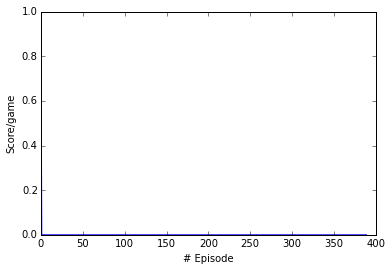

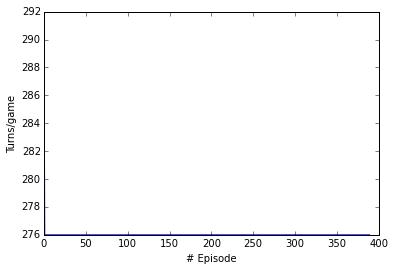

In [7]:
# Show score
%matplotlib inline

# Reload if score doesn't exist
if score_records is None:
    with open(path_scores,'rb') as f:
        score_records = pickle.load(f) 

def moving_avg(arr):
  mm = []
  wnd = 10
  for i in range(len(arr)):
    v = arr[i-wnd:i]
    if len(v)>0:
      mm.append(max(v))
  return mm

plt.figure(1)
plt.xlabel('# Episode')
plt.ylabel('Score/game')
plt.plot(moving_avg(score_records))

plt.figure(2)
plt.xlabel('# Episode')
plt.ylabel('Turns/game')
plt.plot(moving_avg(turn_records))
plt.show()